# Synthpy function and example

## Table of contend
* [Required Packages](###Required-packages-and-example-data)
* [Data preparation function](###Prep_data-function)
* [Optimization](###Optimization-functions)
* ### Visualization
    - [Plot synthetic versus actual](###Synth-plot-function)
    - [Plot the difference between synthetic and actual](###Synth_diffplot-function)
* ### Robustness test
    - [Leave one out](###Leave-one-out)
    - [Permutation test](###Placebo-test)

### Required packages and example data

In [20]:
import pandas as pd
import numpy as np
import cvxpy as cp
import scipy
from scipy.stats import norm
from scipy.optimize import minimize, Bounds, LinearConstraint
import matplotlib.pyplot as plt
df = pd.read_csv("DF_all.csv")

In [2]:
clist = ["bangladesh", "cambodia", "india", "indonesia",
         "lao pdr", "malaysia", "myanmar", "pakistan", "philippines", "vietnam"]

In [3]:
df.head()

,year,Country_no,Country,GDP_G,INF,UNEMP,TRADE,POPTOL,GDP_CAPG,CPI_S,CPI_R,INC1,INC50
0,1995,1,japan,2.631000,-0.127899,3.2,16.390105,125472000,2.390520,67.2,20.0,0.1041,0.0497
1,1996,1,japan,3.133871,0.136600,3.4,18.253868,125757000,2.900141,70.5,17.0,0.1107,0.0495
2,1997,1,japan,0.981229,1.747805,3.4,19.783518,126057000,0.740906,65.7,21.0,0.1048,0.0495
3,1998,1,japan,-1.270330,0.661974,4.1,19.003186,126400000,-1.538244,58.0,25.0,0.1037,0.0494
4,1999,1,japan,-0.333930,-0.341297,4.7,18.125631,126631000,-0.515741,60.0,25.0,0.1063,0.0493


### Prep_data function

In [4]:
class prep_data:
    def __init__(self, df, year, country, target, control,
                 begin, train, validation, treatment,
                 outcome, cov , method = "mean"):
        
        # Catch basic errors
        if target in (control):
            raise ValueError("Target in control")
        if (treatment < validation) | (treatment < train):
            raise ValueError("Treatment must occurs after training/validation")
        
        c = df[df[country].isin(control)] #Donor/control units
        t = df[df[country] == target] #Treated unit
        
        # Get y, outcome variable
        Y1 = t[[year, outcome]].sort_values("year")
        Y1 = Y1[outcome].values
        Y0 = c[[year, country, outcome]].sort_values("year")
        Y0 = Y0.pivot(index = year, columns = country, values = outcome).values


        # Compute X, the predictor from data
        X1 = t[[year, *cov]].sort_values("year")
        X0 = c[[year, country, *cov]].sort_values("year")
        X1_train = X1[(X1.year >= train) & (X1.year < validation)]
        X0_train = X0[(X0.year >= train) & (X0.year < validation)]
        
        if method == "mean":
            X1_train = X1_train[[*cov]].mean().T.values
            X0_train = X0_train[[country, *cov]].groupby(country).mean().T.values
        elif method == "median":
            X1_train = X1_train[[*cov]].mean().T.values
            X0_train = X0_train[[country, *cov]].groupby(country).mean().T.values
        else:
            raise ValueError("Method argument only supports mean and median")
            
            # Standardize, minus mean and divide by standard error
        X1X0_train = np.hstack([X0_train, X1_train.reshape(-1,1)])
        X0_train = (X0_train.T-np.mean(X1X0_train, axis=1))/np.std(X1X0_train, axis=1)
        X1_train = (X1_train.T-np.mean(X1X0_train, axis=1))/np.std(X1X0_train, axis=1)
        
        # make index of time period
        year_norm = min(df[year])
        begin = begin - year_norm #the first period of the data itself (should be 0)
        train = train - year_norm #when training period starts
        validation = validation - year_norm #when validation period starts
        treatment = treatment - year_norm #when treatment happends
        lastperiod = len(df[year].unique())-1 #the last period of the data (last period that receive treatment)
        
        # Put it all in a class
        self.Y0 = Y0
        self.Y1 = Y1
        self.X0 = X0
        self.X1 = X1
        self.X0_train = X0_train
        self.X1_train = X1_train
        self.begin = begin
        self.train = train
        self.validation = validation
        self.treatment = treatment
        self.lastperiod = lastperiod
        self.year_norm = year_norm
        self.predictor = cov
        self.control_unit = control

In [5]:
test_result = prep_data(df, year = "year", country = "Country", target = "thailand",
                 control = clist, begin = 1995, train = 1995, validation = 2005, treatment = 2015,
                 outcome = "GDP_CAPG", cov = ["GDP_G","GDP_CAPG","INF","UNEMP","TRADE","POPTOL","CPI_S","INC1"],
                 method = "mean")

### Optimization functions

In [6]:
# Compute W
def w_opt(V, x1 ,x0 ):
    np.random.seed(451)
    w = cp.Variable(x0.shape[0])
    objective = cp.Minimize(V@( (x1.flatten() - (w@x0) )**2).T) #Least square: sigma V||X1-X0W||
    constraints = [0 <= w, np.ones(x0.shape[0]) @ w == 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    W = w.value
    W[W < 0] = 0
    return W #w is 1 ex: dim(24,)

# Compute rmse
def v_opt(V, y1, y0, x1, x0):
    w = w_opt(V, x1, x0)
    w = w.reshape(-1,1).T #reshape to (1,24) to match y0 (24,27)
    rmse = (np.mean((y1-w@y0.T)**2))**0.5
    return rmse
    
class synth:
    def __init__(self, PD, custom_V = [], method = "SLSQP"): # tried opt: L-BFGS-B
        if len(custom_V) == 0:
            ini = (np.ones(PD.X0_train.shape[1])/PD.X0_train.shape[1]).reshape(-1,1).T #-> shape = 1,8
            cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)}) #sum to one
            bnds = tuple((0,1) for x in ini) #between 0-1
            result = minimize(v_opt, ini, args = (PD.Y1[PD.validation:PD.treatment], PD.Y0[PD.validation:PD.treatment,:], 
                                                  PD.X1_train, PD.X0_train),
                                                  constraints = cons, bounds = bnds, method = method)
            V_star = result['x']
            W_star = w_opt(V_star, PD.X1_train ,PD.X0_train)
        else:
            V_star = custom_V
            W_star = w_opt(V_star, PD.X1_train ,PD.X0_train)
        
    
        # Output
        V_df = pd.DataFrame(list(zip(PD.predictor, list(V_star))),columns = ['Predictor', 'Weight'])
        W_df = pd.DataFrame(list(zip(PD.control_unit, list(W_star))),columns = ['Unit', 'Weight'])
        self.V_star = V_df
        self.W_star = W_df
        self.synthetic = PD.Y0@W_star.reshape(-1,1)
        self.actual = PD.Y1
        self.pretreat_rmse = (np.mean((PD.Y1[PD.validation:PD.treatment]-(PD.Y0[PD.validation:PD.treatment,:]@W_star.reshape(-1,1)))**2))**0.5
        self.TE = self.actual.flatten() - self.synthetic.flatten()
        self.begin = PD.begin
        self.lastperiod = PD.lastperiod
        self.treatyear = PD.treatment
        self.year_norm = PD.year_norm

In [7]:
test_synth = synth(test_result)

C:\Users\prach\AppData\Local\Temp\ipykernel_20516\3872362924.py:26: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = minimize(v_opt, ini, args = (PD.Y1[PD.validation:PD.treatment], PD.Y0[PD.validation:PD.treatment,:],


### Synth plot function

In [8]:
def synth_plot(result, xaxis = "year", yaxis = "variable", legend_loc = "lower left", plot_title = "plot"):
    start = result.begin + result.year_norm
    treat = result.treatyear + result.year_norm
    end = result.lastperiod + result.year_norm
    plt.plot(np.arange(start,end+1,1),result.actual, color="k", label="actual")
    plt.plot(np.arange(start,end+1,1),result.synthetic, color="k",
             linestyle = "--", label = "synthetic")
    plt.axvline((result.treatyear + result.year_norm), color="k", alpha=0.5, linestyle="dotted")
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.legend(loc = legend_loc)
    plt.title(plot_title)
    plt.show()

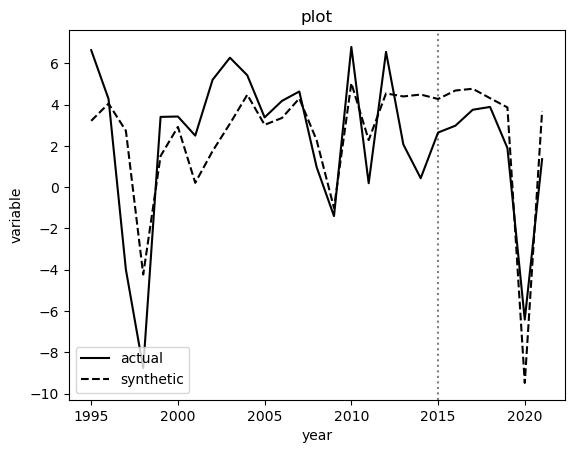

In [9]:
synth_plot(test_synth)

### Synth_diffplot function

In [10]:
def synth_diffplot(result, xaxis = "year", yaxis = "variable", plot_title = "plot"):
    start = result.begin + result.year_norm
    treat = result.treatyear + result.year_norm
    end = result.lastperiod + result.year_norm
    plt.plot(np.arange(start,end+1,1), (result.actual - result.synthetic.flatten()), color="k", label="actual")
    plt.axvline(treat, color="k", alpha=0.5, linestyle="dotted")
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.title(plot_title)
    plt.show()

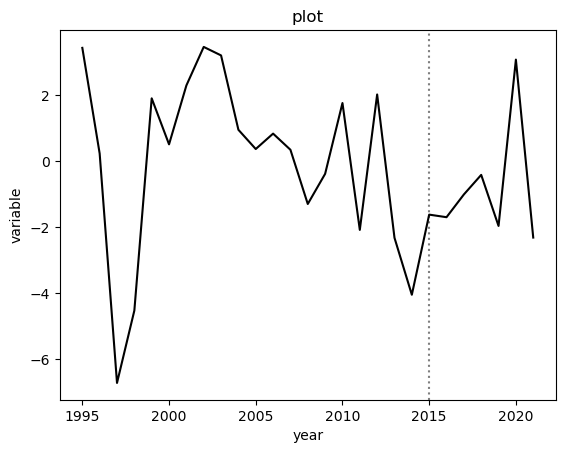

In [11]:
synth_diffplot(test_synth)

In [12]:
test_synth.V_star

,Predictor,Weight
0,GDP_G,3.819945e-01
1,GDP_CAPG,2.030429e-02
2,INF,2.142146e-02
3,UNEMP,3.798355e-02
4,TRADE,4.698131e-01
5,POPTOL,1.648967e-02
6,CPI_S,1.763316e-18
7,INC1,5.199350e-02


In [13]:
test_synth.W_star

,Unit,Weight
0,bangladesh,2.269110e-23
1,cambodia,0.000000e+00
2,india,0.000000e+00
3,indonesia,1.065955e-22
4,lao pdr,0.000000e+00
5,malaysia,2.213652e-01
6,myanmar,0.000000e+00
7,pakistan,6.711957e-02
8,philippines,7.115152e-01
9,vietnam,5.099681e-23


### Leave one out 

In [14]:
def loo(df, year, country, target, control, begin, train, validation, treatment, outcome,
        cov, use_Vbaseline = True, opt_method = "SLSQP", Legend_loc = "lower left" , pred_method = "mean"):
    
    # Compute baseline
    baseline = prep_data(df, year = year, country = country, target = target,
                 control = control, begin = begin, train = train, validation = validation,
                 treatment = treatment, outcome = outcome, cov = cov, method = pred_method)
    
    # Store baseline result
    baseline_result = synth(baseline, method = opt_method)
    Actual = baseline_result.actual
    baseline_synthetic = baseline_result.synthetic
    baseline_V = baseline_result.V_star["Weight"].values
    start = baseline_result.begin + baseline_result.year_norm
    treat = baseline_result.treatyear + baseline_result.year_norm
    end = baseline_result.lastperiod + baseline_result.year_norm
    
    # Plot baseline and actual
    plt.plot(np.arange(start,end+1,1), Actual,color="k", label="actual")
    plt.plot(np.arange(start,end+1,1), baseline_synthetic, color="k", linestyle = "--", label = "synthetic")
    plt.axvline(treat, color="k", alpha=0.5, linestyle="dotted")
    del baseline, baseline_result
    
    # Leaave-one-out loop
    loo_rmse = []
    for i in control:
        loo_control = [x for x in control if x != i]
        loo_prep = prep_data(df, year = year, country = country, target = target,
                 control = loo_control, begin = begin, train = train, validation = validation,
                 treatment = treatment, outcome = outcome, cov = cov, method = pred_method)
        if use_Vbaseline == True:
            loo_result = synth(loo_prep, method = opt_method, custom_V = baseline_V)
        else:
            loo_result = synth(loo_prep, method = opt_method)
        loo_rmse.append(loo_result.pretreat_rmse)
        
        # Plot loo
        if i == control[0]:
            plt.plot(np.arange(start,end + 1,1), loo_result.synthetic,
                    color="k", label="leave-one-out", alpha = 0.15)
        else:
            plt.plot(np.arange(start,end + 1,1), loo_result.synthetic, color="k", alpha = 0.15)
    
    plt.title("Leave-one-out")
    plt.legend(loc = Legend_loc)
    plt.show()
    
    # Return loo RMSE dataframe
    rmse_table = pd.DataFrame(list(zip(control, loo_rmse)),columns =[str(country), 'pretreatment RMSE'])
    return rmse_table

C:\Users\prach\AppData\Local\Temp\ipykernel_20516\3872362924.py:26: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = minimize(v_opt, ini, args = (PD.Y1[PD.validation:PD.treatment], PD.Y0[PD.validation:PD.treatment,:],


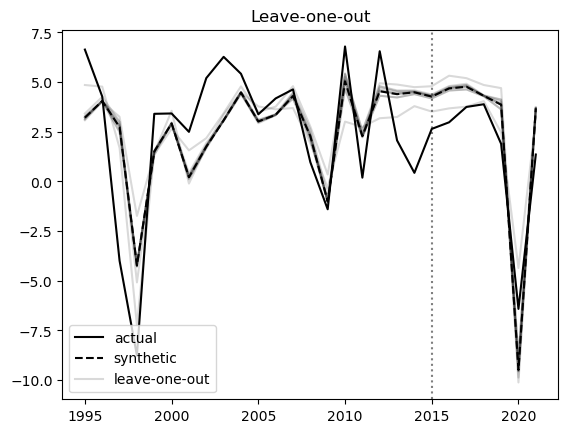

In [15]:
loo_test = loo(df, year = "year", country = "Country", target = "thailand",
                 control = clist, begin = 1995, train = 1995, validation = 2005, treatment = 2015,
                 outcome = "GDP_CAPG", cov = ["GDP_G","GDP_CAPG","INF","UNEMP","TRADE","POPTOL","CPI_S","INC1"],
                 pred_method = "mean", use_Vbaseline = True)

In [16]:
loo_test

,Country,pretreatment RMSE
0,bangladesh,3.184444
1,cambodia,3.210339
2,india,3.129754
3,indonesia,3.124915
4,lao pdr,3.175043
5,malaysia,3.176524
6,myanmar,3.196643
7,pakistan,3.240545
8,philippines,2.897774
9,vietnam,3.183693


### Placebo test

In [90]:
# Standard error for hypothesis test, WIP
def placebo_permu(df, year, country, target, control, 
                  begin, train, validation, treatment, 
                  outcome, cov,  placebo_start, use_Vbaseline = True, 
                  opt_method = "SLSQP", pred_method = "mean", alpha = 0.05):
    
    # Catch basic errors
    if begin > placebo_start:
        raise ValueError("Placebo can't be assigned to period prior to first period")
    if train > placebo_start:
        raise ValueError("No time period to train placebo, set placebo_start to period after train")
    if (alpha < 0) | (alpha > 1):
        raise ValueError("Confidence level must lie between 0 and 1")
        
    # Compute baseline
    baseline = prep_data(df, year = year, country = country, target = target,
                 control = control, begin = begin, train = train, validation = validation,
                 treatment = treatment, outcome = outcome, cov = cov, method = pred_method)
    
    # Store baseline result
    baseline_result = synth(baseline, method = opt_method)
    baseline_diff = baseline_result.actual.flatten() - baseline_result.synthetic.flatten()
    baseline_V = baseline_result.V_star["Weight"].values
    del baseline_result
    
    # Nested loop for Placebo permutation
    TE = []
    for y in (np.arange(placebo_start, treatment, 1)): #year prior to actual treat
        for c in (control): #control units
            loo_control = [x for x in control if x != c]
            pretreat_period = (y - train)/2 #always split pretreatment half/half for train/validation
            placebo_validation = int(train + pretreat_period)
            placebo_prep = prep_data(df, year = year, country = country, target = c,
                    control = loo_control, begin = begin, train = train, validation = placebo_validation,
                    treatment = y, outcome = outcome, cov = cov, method = pred_method)
            if use_Vbaseline == True:
                    placebo_result = synth(placebo_prep, method = opt_method, custom_V = baseline_V)
            else:
                try:
                    placebo_result = synth(placebo_prep, method = opt_method, custom_V = [])
                except:
                    placebo_result = synth(placebo_prep, method = opt_method, custom_V = baseline_V) # incase not converge        
            TE.append(placebo_result.actual.flatten() - placebo_result.synthetic.flatten())
            
    # Compute placebo mean, std and the interval
    z = np.abs(norm.ppf(alpha/2))
    year = np.arange(begin, max(df[year])+1, 1)
    TE_avg = np.mean(TE, axis = 0)
    TE_std = np.std(TE, axis = 0)
    TE_up = TE_avg + z*TE_std
    TE_dw = TE_avg - z*TE_std
    result_table = pd.DataFrame(list(zip(year, baseline_diff, TE_avg, TE_std, TE_up, TE_dw)),
                              columns =["year", "baseline", "placebo_mean", "placebo_std",
                                        "placebo_upperbound", "placebo_lowerbound"])
    
    # Plot result with interval
    plt.errorbar(year, TE_avg, yerr = z*TE_std,fmt ='o', capsize = 6, color = "k")
    plt.plot(year, TE_avg, color = "k", label = "placebo average")
    plt.plot(year, baseline_diff, color = "r", label = "baseline")
    plt.title("Placebo analysis")
    plt.xlabel("Actual and synthetic difference")
    plt.legend()
    plt.show()
    return result_table    


C:\Users\prach\AppData\Local\Temp\ipykernel_20516\3872362924.py:26: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = minimize(v_opt, ini, args = (PD.Y1[PD.validation:PD.treatment], PD.Y0[PD.validation:PD.treatment,:],


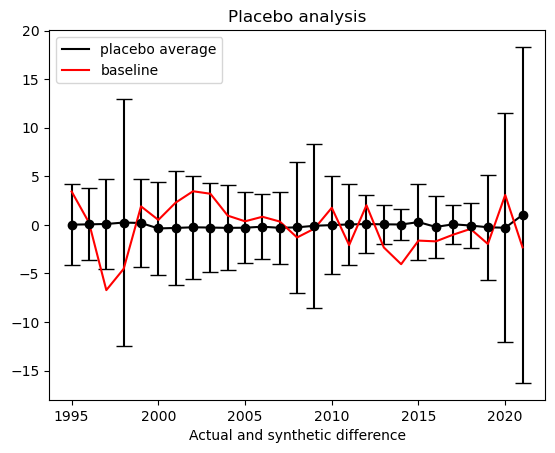

In [91]:
test_permu = placebo_permu(df, year =  "year", country = "Country", target =  "thailand",
                  control = clist, begin = 1995, train = 1995, validation = 2005, treatment = 2015, 
                  outcome = "GDP_CAPG", cov= ["GDP_G","GDP_CAPG","INF","UNEMP","TRADE","POPTOL","CPI_S","INC1"],
                  placebo_start = 2010, use_Vbaseline = True, 
                  opt_method = "SLSQP", pred_method = "mean", alpha = 0.05)

[back to top](##Table-of-contend)